In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
import libpysal

In [ ]:
place_name = "Tel Aviv,Israel"
G = ox.graph_from_place(place_name, network_type='all', buffer_dist = 2000)
G_proj = ox.project_graph(G,to_crs='epsg:6984')
G_nodes_proj, G_edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
edges = G_edges_proj.unary_union

<AxesSubplot:>

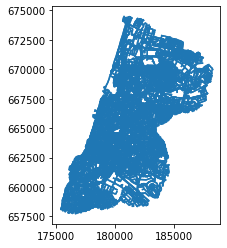

In [3]:
G_edges_proj.plot()

In [4]:
# read the data
pop = gpd.read_file('/Users/xqy/Desktop/city/Tel_Aviv/CPoPGrid.gpkg')
green = gpd.read_file('/Users/xqy/Desktop/city/Tel_Aviv/PublicGreenspaces_WGS84.gpkg')
boundry= gpd.read_file('/Users/xqy/Desktop/city/Tel_Aviv/citybound_WGS84.shp')

In [5]:
def green_data_prepocessing(green,boundry,buffer, destination = 'centroids'):
    """
    green space data preprocessing:
    green is the green space geodataframe;
    boundry is the city's administrative boundry;
    destination represents the fake gate of green space, 'centroids' means using centroids of 
    green space as access point. 'Entrance' means using the intersections points;
    buffer is added around the green space to do the intersection with road network, usually 20m

    """
     
    # transfer the CRS
    boundry = boundry.to_crs(epsg = 6984) 
    green =  green.to_crs(epsg = 6984)
    
    # clip green space within the buffered city boundry
    # first to add a buffer around the boundry to ensure people 
    # live around the edge of the boundry could access the green space outside the city but still within distance threshold
    boundry_buffer = boundry.buffer(buffer)
    green_clip = green.clip(boundry_buffer,keep_geom_type=False)
    
    # merge the overlap green space into one polygon
    s_ = gpd.GeoDataFrame(geometry=[green_clip.unary_union]).explode(
        index_parts=False).reset_index(drop=True).set_crs(epsg = 6984)
    s_ = gpd.sjoin(s_, green_clip, how='left').drop(columns=['index_right'])
    green_dis = s_.dissolve(s_.index, aggfunc='first')
    # reset the index 
    green_dis =green_dis.reset_index(drop=True)
    #create the buffer of green space, ususally 20m, prepare for intersetion to get the accesses
    green_dis['buffer_20m'] = green_dis['geometry'].buffer(20)
    
    # define the green areas that overlap with each other within 20m as the same component
    W = libpysal.weights.fuzzy_contiguity(green_dis['buffer_20m'])
    green_dis['green_components']= W.component_labels
    green_space = green_dis.dissolve('green_components')

    
    #create the centroid of the green space
    green_space['centroids'] = green_space['geometry'].centroid
    #calculate the area of the green space
    green_space['area'] = green_space['geometry'].area
    # select area >400m2
    green_space = green_space[green_space['area'] > 400]
    green_space = green_space.reset_index(drop=True)
    
    entrance = []  
    # choose different fake gate model
    # use centroid of green space 
    if destination == 'centroids':
        green_access = green_space[['centroids','area']]
        green_access.rename(columns = {'centroids': 'geometry'}, inplace = True)
        green_access['park_id'] = list(range(len(green_space)))
        
    
    # use the intersection points: the road network and buffered green space polygon
    elif destination == 'Entrance':
        # add the buffer of 20m for each components
        green_space['buffer'] = green_space['geometry'].buffer(20)
        for i in range(len(green_space)):
            green_area = green_space.loc[i,'geometry'].area
            intersection = green_space['buffer'][i].boundary.intersection(edges)
            try:
                for point in intersection:
                    dic = {'geometry': point, 'area': green_area, 'park_id': i}
                    entrance.append(dic)
            except: continue
    green_access = gpd.GeoDataFrame(entrance)
    # if the distance of two fake entrances is less than 50m, then keep the first entrance
    green_access['buffer'] = green_access['geometry'].buffer(25)
    w_e = libpysal.weights.fuzzy_contiguity(green_access['buffer'])
    green_access['entrance_components']= w_e.component_labels
    # Delete duplicate rows based on specific columns 
    green_access =  green_access.drop_duplicates(subset=["entrance_components"], keep='first')
    green_access = green_access.reset_index(drop=True)
    
    return green_access   

In [ ]:
green_access = green_data_prepocessing(green,boundry,1000, destination = 'Entrance')

In [7]:
green_access.head()

,geometry,area,park_id,buffer,entrance_components
0,POINT (176441.268 659804.027),31874.967646,0,"POLYGON ((176466.268 659804.027, 176466.147 65...",0
1,POINT (176699.977 659834.149),31874.967646,0,"POLYGON ((176724.977 659834.149, 176724.857 65...",1
2,POINT (176115.382 660012.813),31874.967646,0,"POLYGON ((176140.382 660012.813, 176140.262 66...",2
3,POINT (176369.674 660073.168),31874.967646,0,"POLYGON ((176394.674 660073.168, 176394.554 66...",3
4,POINT (176318.461 659879.769),31874.967646,0,"POLYGON ((176343.461 659879.769, 176343.341 65...",4


In [8]:
# preprocessing population data
def population_data_prepocessing(pop, boundry, distance_threshold):
    
    """
    population data prepocessing:
    pop is the population geodataframe;
    boundry is the city's administrative boundry; 
    distance_threshold is the walking or driving distance; 
    
    """
    
    # transfer the CRS
    boundry = boundry.to_crs(epsg =  6984) 
    pop =  pop.to_crs(epsg =  6984)
    
    # clip population within the city boundry
    boundry_2_buffer = boundry.buffer(2*distance_threshold)
    pop_clip = pop.clip(boundry_2_buffer,keep_geom_type=False)

    # remove grid cell if its population is less than 10 in case of extreme value
    pop_remove = pop_clip[(pop_clip['PoP2015_Number'] < 10) == False]
    pop_remove['area'] = pop_remove['geometry'].area
    
    # remove boundry population if the area of grid cell is less than half of the regular area
    pop_remove_bound = pop_remove[pop_remove['area'] > pop_remove['area'].max()*0.99]
    
    #create the centroid of the population grid cell
    pop_remove_bound['centroids'] = pop_remove_bound['geometry'].centroid
    #create the buffer of each grid cell, which equals the distance threshold
    pop_remove_bound['buffer'] = pop_remove_bound['geometry'].buffer(distance_threshold)
    # reset the index 
    pop_remove_bound  = pop_remove_bound.reset_index(drop=True)
    
    return pop_remove_bound


In [ ]:
pop_remove_bound = population_data_prepocessing(pop, boundry, 1000)

In [10]:
pop_remove_bound.head()

,grid_id,PoP2015_Number,geometry,area,centroids,buffer
0,2081,372,"POLYGON ((178866.471 660025.403, 178865.625 65...",45005.525059,POINT (178759.976 659919.755),"POLYGON ((178870.466 661025.395, 178968.463 66..."
1,2080,825,"POLYGON ((178654.330 660026.250, 178653.480 65...",45005.544302,POINT (178547.833 659920.604),"POLYGON ((178658.346 661026.242, 178756.342 66..."
2,2079,968,"POLYGON ((178442.188 660027.102, 178441.334 65...",45005.563645,POINT (178335.690 659921.459),"POLYGON ((178446.225 661027.094, 178544.222 66..."
3,2078,989,"POLYGON ((178230.047 660027.959, 178229.189 65...",45005.583088,POINT (178123.546 659922.317),"POLYGON ((178234.105 661027.951, 178332.101 66..."
4,2077,961,"POLYGON ((178017.906 660028.820, 178017.043 65...",45005.602630,POINT (177911.403 659923.180),"POLYGON ((178021.984 661028.811, 178119.981 66..."


In [11]:
def get_the_index_within_dist(pop_clip,green_access ):
    
    """
    this step is to create a dataframe with pairs of population grid cell and green space
    whose euclidian distance is smaller than distance threshold
    
    """
  
    k= []
    for i in range(len(pop_clip)):
        for j in range(len(green_access)):
            if green_access['geometry'][j].within(pop_clip['buffer'][i]):
            #distance. = pop_clip['centroids'][i].distance(access_point['geometry'][j])
                index = {'pop_index': i, 'green_index': j,
                         'green_area': green_access['area'][j],
                         'park_id': green_access['park_id'][j],
                         'pop_num': pop_clip.loc[i, 'PoP2015_Number']}
                k.append(index)
    df_index = pd.DataFrame(k)
    return df_index

In [12]:
df_index = get_the_index_within_dist(pop_remove_bound,green_access )

In [13]:
df_index.head()

,pop_index,green_index,green_area,park_id,pop_num
0,0,282,7595.846248,80,372
1,0,283,7595.846248,80,372
2,0,284,7595.846248,80,372
3,0,285,7595.846248,80,372
4,0,286,4049.958831,81,372


In [14]:
def origin_node(df_index,pop_clip):
    # get the unique value of pop index
    pop_unique = df_index['pop_index'].unique()
    
    orig_id = []
    # get the nearest node id of each centroid of population grid cell
    for i in range(len(pop_unique)):
        pop_index = pop_unique[i]
        orig_node = ox.distance.nearest_nodes(G_proj,pop_clip.loc[pop_index,'centroids'].x,
                                                pop_clip.loc[pop_index,'centroids'].y)
        dic = {'pop_index':pop_unique[i],'orig_node':orig_node}
        orig_id.append(dic)
    orig_id_df = pd.DataFrame(orig_id)
    return orig_id_df

In [15]:
orig_id_df = origin_node(df_index,pop_remove_bound)

In [16]:
orig_id_df.head()

,pop_index,orig_node
0,0,1257346786
1,1,1257340506
2,2,648039925
3,3,720577527
4,4,3394434387


In [17]:
def target_node(df_index, green_access):
    # get the unique value of green index
    green_unique = df_index['green_index'].unique()
    target_id = []
    # get the nearest node id of each green space
    for i in range(len(green_unique)):
        green_index = green_unique[i]
        target_node = ox.distance.nearest_nodes(G_proj,green_access.loc[green_index,'geometry'].x,
                                                green_access.loc[green_index,'geometry'].y)
        dic = {'green_index':green_unique[i],'target_node': target_node}
        target_id.append(dic)
    target_id_df = pd.DataFrame(target_id)
    return target_id_df

In [18]:
target_id_df =  target_node(df_index, green_access)

In [19]:
target_id_df.head()

,green_index,target_node
0,282,1225577241
1,283,2931878489
2,284,1458980341
3,285,1458980341
4,286,1135811188


In [20]:
pop_merge = pd.merge(df_index, orig_id_df, how = 'left', on = 'pop_index' )
pop_merge.head()

,pop_index,green_index,green_area,park_id,pop_num,orig_node
0,0,282,7595.846248,80,372,1257346786
1,0,283,7595.846248,80,372,1257346786
2,0,284,7595.846248,80,372,1257346786
3,0,285,7595.846248,80,372,1257346786
4,0,286,4049.958831,81,372,1257346786


In [21]:
merge = pd.merge(pop_merge, target_id_df, how = 'left', on = 'green_index' )
merge.head()

,pop_index,green_index,green_area,park_id,pop_num,orig_node,target_node
0,0,282,7595.846248,80,372,1257346786,1225577241
1,0,283,7595.846248,80,372,1257346786,2931878489
2,0,284,7595.846248,80,372,1257346786,1458980341
3,0,285,7595.846248,80,372,1257346786,1458980341
4,0,286,4049.958831,81,372,1257346786,1135811188


In [22]:
def OD_Matrix(merge):
    """
    get the real distance between each pair of population grid cell and green space 
    """
    distance = []
    for i in range(len(merge)):
        try: 
            orig_node = merge.loc[i, 'orig_node']
            target_node = merge.loc[i, 'target_node']
            dist = nx.shortest_path_length(G_proj, source=orig_node, 
                                           target=target_node, weight='length')
            distance.append(dist)
        except:
            distance.append(np.nan)
    merge['distance'] = distance
    return merge

In [23]:
merge_dist = OD_Matrix(merge)

In [24]:
merge_dist.head()

,pop_index,green_index,green_area,park_id,pop_num,orig_node,target_node,distance
0,0,282,7595.846248,80,372,1257346786,1225577241,1506.154
1,0,283,7595.846248,80,372,1257346786,2931878489,1135.568
2,0,284,7595.846248,80,372,1257346786,1458980341,603.262
3,0,285,7595.846248,80,372,1257346786,1458980341,603.262
4,0,286,4049.958831,81,372,1257346786,1135811188,996.627


In [25]:
## first choose 1000m as catchment size
OD_mile = merge_dist[merge_dist['distance'] < 1000]
def neareat_entrance(OD_mile): # OD_mile is the OD Matrix after selection, e.g real_distance < 1km
    unique = OD_mile['pop_index'].unique()
    OD_nearest_E = []
    for i in unique:
        df = OD_mile.loc[OD_mile['pop_index'] == i]
        df1 = df.groupby('park_id').min('distance')
        for j in df1.index:
            dic = {'pop_index': i,'park_id': j,'distance':df1.loc[j,'distance'],
              'green_area': df1.loc[j,'green_area'], 'pop_num':df1.loc[j,'pop_num']}
            OD_nearest_E.append(dic)
    OD_nearest_E = pd.DataFrame(OD_nearest_E)
    return OD_nearest_E

In [26]:
OD_nearest_E = neareat_entrance(OD_mile)

In [27]:
OD_nearest_E.head()

,pop_index,park_id,distance,green_area,pop_num
0,0,80,603.262,7595.846248,372
1,0,81,996.627,4049.958831,372
2,0,83,928.205,1111.899216,372
3,1,80,515.734,7595.846248,825
4,1,81,909.099,4049.958831,825


In [28]:
def M2tsfca (OD_nearest_E, distance_threshold):
    
    OD_nearest_E['weight'] = (np.exp(-(OD_nearest_E['distance']/distance_threshold)**2/2-np.exp(-1/2)))/(1-np.exp(-1/2)).astype(float) 
    OD_nearest_E['weighted_pop'] = OD_nearest_E['weight'] * OD_nearest_E['pop_num']

    # get the sum of weighted population each green space has to serve.
    s_w_p = pd.DataFrame(OD_nearest_E.groupby('park_id').sum('weighted_pop')['weighted_pop'])
    # delete other columns, because they are useless after groupby
    s_w_p = s_w_p.rename({'weighted_pop':'sum_weighted_pop'},axis = 1)
    middle = pd.merge(OD_nearest_E,s_w_p, how = 'left', on = 'park_id')
    # calculate the supply-demand ratio for each green space
    middle['green_supply'] = middle['green_area']/middle['sum_weighted_pop']
    
    # caculate the accessbility score for each green space that each population grid cell could reach
    middle['access_score'] = middle['weight'] * middle['green_supply']
    # add the scores for each population grid cell
    pop_score_df = pd.DataFrame(middle.groupby('pop_index').sum('access_score')['access_score'])

    # calculate the mean distance of all the green space each population grid cell could reach
    mean_dist = middle.groupby('pop_index').mean('distance')['distance']
    pop_score_df['mean_dist'] = mean_dist

    # calculate the mean area of all the green space each population grid cell could reach
    mean_area = middle.groupby('pop_index').mean('green_area')['green_area']
    pop_score_df['mean_area'] = mean_area

    # calculate the mean supply_demand ratio of all the green space each population grid cell could reach
    mean_supply = middle.groupby('pop_index').mean('green_supply')['green_supply']
    pop_score_df['mean_supply'] = mean_supply

    return pop_score_df

In [29]:
pop_score_df = M2tsfca (OD_nearest_E,1000)
pop_score_df.head()

,access_score,mean_dist,mean_area,mean_supply
pop_index,,,,
0,0.740397,842.698000,4252.568098,0.246100
1,1.161538,813.293750,4730.442005,0.294080
2,0.396331,711.190000,7595.846248,0.368309
5,1.798681,759.018333,4354.142225,0.288954
6,1.968042,621.311333,4354.142225,0.288954


In [30]:
pop_remove_bound['pop_index'] = list(range(len(pop_remove_bound)))
# merge the score dataframe and population grid cell together
score_1000m = pd.merge(pop_remove_bound, pop_score_df, how = 'left', on='pop_index')
score_1000m = score_1000m[['PoP2015_Number','geometry','access_score','mean_dist','mean_area','mean_supply']]
# normalize the score 
score_1000m['normalize'] = score_1000m['access_score']/score_1000m['PoP2015_Number']

In [33]:
score_1000m.head(10)

,PoP2015_Number,geometry,access_score,mean_dist,mean_area,mean_supply,normalize
0,372,"POLYGON ((178865.625 659813.259, 178653.480 65...",0.740397,842.698000,4252.568098,0.246100,0.001990
1,825,"POLYGON ((178653.480 659814.107, 178441.334 65...",1.161538,813.293750,4730.442005,0.294080,0.001408
2,968,"POLYGON ((178441.334 659814.959, 178229.189 65...",0.396331,711.190000,7595.846248,0.368309,0.000409
3,989,"POLYGON ((178229.189 659815.815, 178017.043 65...",NaN,NaN,NaN,NaN,NaN
4,961,"POLYGON ((178017.043 659816.676, 177804.897 65...",NaN,NaN,NaN,NaN,NaN
5,430,"POLYGON ((178866.471 660025.403, 178654.330 66...",1.798681,759.018333,4354.142225,0.288954,0.004183
6,680,"POLYGON ((178654.330 660026.250, 178442.188 66...",1.968042,621.311333,4354.142225,0.288954,0.002894
7,835,"POLYGON ((178442.188 660027.102, 178230.047 66...",0.759779,819.169667,4252.568098,0.246100,0.000910
8,920,"POLYGON ((178230.047 660027.959, 178017.906 66...",1.210756,766.254000,4730.442005,0.294080,0.001316
9,933,"POLYGON ((178017.906 660028.820, 177805.765 66...",0.681586,820.953500,5822.902539,0.343781,0.000731
